**A Structured Output Agent in LangChain (or other LLM frameworks) refers to an agent that produces responses in a specific structured format, such as JSON, dictionaries, or other structured data types. These agents are particularly useful when you want to ensure that your responses conform to a defined schema, making it easier to parse, validate, and utilize in downstream applications.**

Why Use a Structured Output Agent?
- Controlled Responses: Ensures that the outputs follow a specific format, reducing ambiguity.
- Data Validation: Useful when you want the model output to fit predefined structures, like for APIs or database entries.
- Automation: Makes integration with systems like dashboards, ETL pipelines, or business workflows easier.

In [31]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import HumanMessage
from pydantic import Field, BaseModel

In [32]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm= ChatGoogleGenerativeAI(model='gemini-1.5-pro')

In [ ]:
# Creating a tool with tavily_search

@tool
def call_tool(prompt:str):
    """Should do a web search to find the required city details"""
    search= DuckDuckGoSearchRun()
    response= search.invoke(prompt)
    return response

#search= TavilySearchResults()

In [34]:
#search= TavilySearchResults()
tools= [call_tool]

llm_with_tools= llm.bind_tools(tools)

tool_node= ToolNode(tools)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


**The BaseModel class is a core component of Pydantic, which is used extensively in Python applications for data validation, type checking, and parsing. It's particularly useful when working with APIs, web frameworks like FastAPI, and other scenarios where you need to enforce data structure and ensure data integrity.**

**Here's an overview of the BaseModel class, along with some examples to demonstrate how you can use it effectively.**

**This code defines a Pydantic model called CityDetails using the BaseModel class. Let's break it down:**

**Class Definition:**

- CityDetails inherits from BaseModel, making it a data validation model.

- Fields with Type Annotations:

- state_name: A string representing the state name of a city.

- state_capital: A string representing the capital of that state.

- country_name: A string representing the country name where the city is located.

- country_capital: A string representing the capital of that country.

**Field Descriptions:**

Each field uses Field() to provide a description that helps clarify what information each attribute represents.

**Purpose:**

The model validates and structures data related to cities.
Useful for ensuring that any data related to cities has the correct structure before processing.
Helpful in APIs (like FastAPI) to generate self-documenting endpoints.

In [35]:
class CityDetails(BaseModel):
    """Respond to the user with this"""
    state_name: str = Field(description="State name of the city")
    state_capital: str = Field(description="State capital of the city")
    country_name: str = Field(description="Country name of the city")
    country_capital: str = Field(description="Country capital of the city")
    

In [36]:
# Inherit 'messages' key from MessagesState, which is a list of chat messages
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: CityDetails

In [37]:
llm_with_structured_output = llm.with_structured_output(CityDetails)

In [38]:
def call_model(state: AgentState): 
    print(f" this is 01 input from call model {state}")
    messages= state['messages']
    response= llm_with_tools.invoke(messages)
    print(f"this is 02 response from call model  {response}")
    return {'messages': [response]}

In [39]:
def router_function(state: AgentState):
    messages= state['messages']
    last_message= messages[-1]
    if last_message.tool_calls:
        return 'tools'
    else:
        return 'respond'

In [40]:
def respond(state: AgentState):
    print(f"here is 03 state from respond {state}")
    messages= state['messages']
    response= llm_with_structured_output.invoke([HumanMessage(content=messages[-1].content)])
    print(f"this is 04 response from respond{response}")
    return {"final_response": response}

In [41]:
# Defining the LangGraph

workflow= StateGraph(AgentState)
workflow.add_node('agent', call_model)
workflow.add_node('tools', tool_node)
workflow.add_node('respond', respond)

workflow.set_entry_point("agent")
workflow.add_conditional_edges('agent', router_function, {'tools':'tools', 'respond':'respond'})
workflow.add_edge('tools', 'agent')
workflow.add_edge('respond', END)
app= workflow.compile()

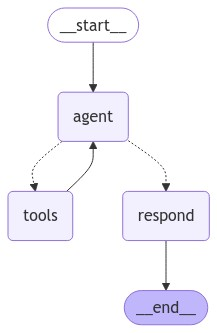

In [42]:
from IPython.display import Image, display
# View
display(Image(app.get_graph().draw_mermaid_png()))

In [43]:
response= app.invoke(input={"messages":[("human", "Tell me about the city details for chennai?")]})
answer= response['final_response']


 this is 01 input from call model {'messages': [HumanMessage(content='Tell me about the city details for chennai?', additional_kwargs={}, response_metadata={}, id='f7883560-c60e-41b7-ad09-f7c05eaf643a')]}
{'name': 'call_tool', 'description': 'Should do a web search to find the required city details', 'parameters': {'type_': 6, 'description': 'Should do a web search to find the required city details', 'properties': {'prompt': {'type_': 0, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['prompt'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}


ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.tools[0].function_declarations[0].parameters.properties[prompt].type: must be specified


In [44]:
print(answer)

NameError: name 'answer' is not defined